In [68]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import pandas as pd
chart = pd.read_csv('data.csv')

In [3]:
chart.columns

Index(['Unnamed: 0', 'ID', 'Name', 'Age', 'Photo', 'Nationality', 'Flag',
       'Overall', 'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',
       'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', 'Position',
       'Jersey Number', 'Joined', 'Loaned From', 'Contract Valid Until',
       'Height', 'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW',
       'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM',
       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Crossing',
       'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingT

In [4]:
GK_df = chart[chart.Position == "GK"]
ST_df = chart[chart.Position.isin(["ST", "LF", "RF", "CF", "RS", "LS", "LW", "RW"])]
MD_df = chart[chart.Position.isin(["RM", "LM", "CAM", "CDM", "LCM", "RCM", "RDM", "LDM", "RAM", "LAM"])]
DF_df = chart[chart.Position.isin(["CB", "LB", "RB", "RCB", "LCB", "RWB", "LWB"])]

In [5]:
GK_df.columns

Index(['Unnamed: 0', 'ID', 'Name', 'Age', 'Photo', 'Nationality', 'Flag',
       'Overall', 'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',
       'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', 'Position',
       'Jersey Number', 'Joined', 'Loaned From', 'Contract Valid Until',
       'Height', 'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW',
       'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM',
       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Crossing',
       'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingT

In [35]:
import re
pattern = r'\d+\.?\d?'
matches = re.findall(pattern, "$600.5K")

def convert_value(value):
    pattern = r'\d+\.?\d?'
    if value.endswith("K"):
        matches = float(re.findall(pattern, value)[0])*1000
    else:
        matches = float(re.findall(pattern, value)[0])*1000000
    return matches

def convert_height(height):
    split = height.split("'")
    height = int(split[0])*12 + int(split[1])
    return height

In [44]:
def preprocess_df(data):
    final_df = data.drop(columns = ['Unnamed: 0', 'ID','Photo', 'Nationality', 'Flag','Club','Club Logo','LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW',
       'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'Wage',
       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Position', 'Preferred Foot',
                                  'Real Face', 'Jersey Number', 'Joined', 'Loaned From', 'Contract Valid Until', 'Release Clause'], axis = 1)
    final_df.dropna(inplace = True)
    target = final_df['Value']
    final_df.drop(columns=['Value'], inplace=True)
    new_table = pd.concat([final_df, target], axis=1)
    weight_new = list(new_table.Weight)
    clean_weight = [int(item.replace('lbs', "")) for item in weight_new]
    new_table["Weight"] = clean_weight
    height_new = list(new_table.Height)
    final_height = [convert_height(item) for item in height_new]
    new_table["Height"] = final_height
    new_values = [convert_value(item) for item in list(new_table.Value)]
    new_table["Value"] = new_values
    
    list_body = list(new_table['Body Type'])
    names = ['Akinfenwa', 'PLAYER_BODY_TYPE_25', 'Shaqiri', 'Messi', 'Neymar', 'Courtois', 'C. Ronaldo']
    for idx, item in enumerate(list_body):
        if item in names:
            list_body[idx] = "Lean"
    new_table['Body Type'] = list_body
    test_df = new_table.set_index("Name")
    dummies_df = test_df[['Body Type', 'Work Rate']]
    target_final = test_df.Value
    test_df.drop(columns = ['Body Type', 'Work Rate', 'Value'], axis = 1, inplace = True)
    scaler = StandardScaler()
    scaled_df = pd.DataFrame(scaler.fit_transform(test_df), columns = test_df.columns, index = test_df.index)
    dummies_final = pd.get_dummies(dummies_df)
    dummies_final.drop(columns = ["Body Type_Stocky"], inplace = True)
    final_df = pd.concat([scaled_df, dummies_final], axis = 1)
    return dict(test = test_df, final = final_df, target = target_final)
    

In [49]:
GK_final = preprocess_df(GK_df)['final']
GK_target = preprocess_df(GK_df)['target']

len(GK_final) == len(GK_target)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


True

In [50]:
ST_final = preprocess_df(ST_df)['final']
ST_target = preprocess_df(ST_df)['target']

len(ST_final) == len(ST_target)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


True

In [51]:
DF_final = preprocess_df(DF_df)['final']
DF_target = preprocess_df(DF_df)['target']

len(DF_final) == len(DF_target)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


True

In [55]:
MD_final = preprocess_df(MD_df)['final']
MD_target = preprocess_df(MD_df)['target']

len(MD_final) == len(MD_target)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


True

In [8]:
pd.set_option('display.max_columns', 100)
chart.head(1)

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Real Face,Position,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,https://cdn.sofifa.org/teams/2/light/241.png,€110.5M,€565K,2202,Left,5.0,4.0,4.0,Medium/ Medium,Messi,Yes,RF,10.0,"Jul 1, 2004",NaN,2021,5'7,159lbs,88+2,88+2,88+2,92+2,93+2,93+2,93+2,92+2,93+2,93+2,93+2,91+2,84+2,84+2,84+2,91+2,64+2,61+2,61+2,61+2,64+2,59+2,47+2,47+2,47+2,59+2,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M


In [9]:
chart.shape

(18207, 89)

In [10]:
final_df = chart.drop(columns = ['Unnamed: 0', 'ID','Photo', 'Nationality', 'Flag','Club','Club Logo','LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW',
       'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM',
       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Position', 'Preferred Foot', 'Wage',
                                  'Real Face', 'Jersey Number', 'Joined', 'Loaned From', 'Contract Valid Until', 'Release Clause'], axis = 1)

In [11]:
final_df.shape

(18207, 47)

In [12]:
final_df.isna().sum()

Name                         0
Age                          0
Overall                      0
Potential                    0
Value                        0
Special                      0
International Reputation    48
Weak Foot                   48
Skill Moves                 48
Work Rate                   48
Body Type                   48
Height                      48
Weight                      48
Crossing                    48
Finishing                   48
HeadingAccuracy             48
ShortPassing                48
Volleys                     48
Dribbling                   48
Curve                       48
FKAccuracy                  48
LongPassing                 48
BallControl                 48
Acceleration                48
SprintSpeed                 48
Agility                     48
Reactions                   48
Balance                     48
ShotPower                   48
Jumping                     48
Stamina                     48
Strength                    48
LongShot

In [13]:
final_df.dropna(inplace = True)

In [14]:
final_df.shape

(18159, 47)

In [15]:
final_df.columns

Index(['Name', 'Age', 'Overall', 'Potential', 'Value', 'Special',
       'International Reputation', 'Weak Foot', 'Skill Moves', 'Work Rate',
       'Body Type', 'Height', 'Weight', 'Crossing', 'Finishing',
       'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
       'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes'],
      dtype='object')

In [16]:
target = final_df['Value']
final_df.drop(columns=['Value'], inplace=True)
new_table = pd.concat([final_df, target], axis=1)
new_table.head()

,Name,Age,Overall,Potential,Special,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Height,Weight,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Value
0,L. Messi,31,94,94,2202,5.0,4.0,4.0,Medium/ Medium,Messi,5'7,159lbs,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€110.5M
1,Cristiano Ronaldo,33,94,94,2228,5.0,4.0,5.0,High/ Low,C. Ronaldo,6'2,183lbs,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€77M
2,Neymar Jr,26,92,93,2143,5.0,5.0,5.0,High/ Medium,Neymar,5'9,150lbs,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€118.5M
3,De Gea,27,91,93,1471,4.0,3.0,1.0,Medium/ Medium,Lean,6'4,168lbs,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€72M
4,K. De Bruyne,27,91,92,2281,4.0,5.0,4.0,High/ High,Normal,5'11,154lbs,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€102M


In [17]:
new_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18159 entries, 0 to 18206
Data columns (total 47 columns):
Name                        18159 non-null object
Age                         18159 non-null int64
Overall                     18159 non-null int64
Potential                   18159 non-null int64
Special                     18159 non-null int64
International Reputation    18159 non-null float64
Weak Foot                   18159 non-null float64
Skill Moves                 18159 non-null float64
Work Rate                   18159 non-null object
Body Type                   18159 non-null object
Height                      18159 non-null object
Weight                      18159 non-null object
Crossing                    18159 non-null float64
Finishing                   18159 non-null float64
HeadingAccuracy             18159 non-null float64
ShortPassing                18159 non-null float64
Volleys                     18159 non-null float64
Dribbling                   18159 non

In [18]:
weight_new = list(new_table.Weight)

In [19]:
clean_weight = [int(item.replace('lbs', "")) for item in weight_new]

In [20]:
type(clean_weight[0])

int

In [21]:
new_table["Weight"] = clean_weight

In [22]:
new_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18159 entries, 0 to 18206
Data columns (total 47 columns):
Name                        18159 non-null object
Age                         18159 non-null int64
Overall                     18159 non-null int64
Potential                   18159 non-null int64
Special                     18159 non-null int64
International Reputation    18159 non-null float64
Weak Foot                   18159 non-null float64
Skill Moves                 18159 non-null float64
Work Rate                   18159 non-null object
Body Type                   18159 non-null object
Height                      18159 non-null object
Weight                      18159 non-null int64
Crossing                    18159 non-null float64
Finishing                   18159 non-null float64
HeadingAccuracy             18159 non-null float64
ShortPassing                18159 non-null float64
Volleys                     18159 non-null float64
Dribbling                   18159 non-

In [23]:
height_new = list(new_table.Height)

In [24]:
height_new[:5]

["5'7", "6'2", "5'9", "6'4", "5'11"]

In [25]:
def convert_height(height):
    split = height.split("'")
    height = int(split[0])*12 + int(split[1])
    return height

In [26]:
final_height = [convert_height(item) for item in height_new]

In [27]:
final_height[:5]

[67, 74, 69, 76, 71]

In [28]:
new_table["Height"] = final_height

In [29]:
new_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18159 entries, 0 to 18206
Data columns (total 47 columns):
Name                        18159 non-null object
Age                         18159 non-null int64
Overall                     18159 non-null int64
Potential                   18159 non-null int64
Special                     18159 non-null int64
International Reputation    18159 non-null float64
Weak Foot                   18159 non-null float64
Skill Moves                 18159 non-null float64
Work Rate                   18159 non-null object
Body Type                   18159 non-null object
Height                      18159 non-null int64
Weight                      18159 non-null int64
Crossing                    18159 non-null float64
Finishing                   18159 non-null float64
HeadingAccuracy             18159 non-null float64
ShortPassing                18159 non-null float64
Volleys                     18159 non-null float64
Dribbling                   18159 non-n

In [30]:
import re
pattern = r'\d+\.?\d?'
matches = re.findall(pattern, "$600.5K")

def convert_value(value):
    pattern = r'\d+\.?\d?'
    if value.endswith("K"):
        matches = float(re.findall(pattern, value)[0])*1000
    else:
        matches = float(re.findall(pattern, value)[0])*1000000
    return matches

In [31]:
new_values = [convert_value(item) for item in list(new_table.Value)]

In [32]:
new_values[:5]

[110500000.0, 77000000.0, 118500000.0, 72000000.0, 102000000.0]

In [33]:
new_table["Value"] = new_values

In [34]:
new_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18159 entries, 0 to 18206
Data columns (total 47 columns):
Name                        18159 non-null object
Age                         18159 non-null int64
Overall                     18159 non-null int64
Potential                   18159 non-null int64
Special                     18159 non-null int64
International Reputation    18159 non-null float64
Weak Foot                   18159 non-null float64
Skill Moves                 18159 non-null float64
Work Rate                   18159 non-null object
Body Type                   18159 non-null object
Height                      18159 non-null int64
Weight                      18159 non-null int64
Crossing                    18159 non-null float64
Finishing                   18159 non-null float64
HeadingAccuracy             18159 non-null float64
ShortPassing                18159 non-null float64
Volleys                     18159 non-null float64
Dribbling                   18159 non-n

In [ ]:
new_table['Body Type'].value_counts()

In [ ]:
list_body = list(new_table['Body Type'])
names = ['Akinfenwa', 'PLAYER_BODY_TYPE_25', 'Shaqiri', 'Messi', 'Neymar', 'Courtois', 'C. Ronaldo']    

In [ ]:

for idx, item in enumerate(list_body):
    if item in names:
        list_body[idx] = "Lean"

In [ ]:
set(list_body)

In [ ]:
list_body[:5]

In [ ]:
new_table['Body Type'] = list_body

In [ ]:
new_table['Body Type'].value_counts()

In [ ]:
new_table.head()

In [ ]:
test = new_table.set_index("Name")

In [ ]:
test.head()

In [ ]:
test.shape

In [ ]:
plot_table = test[:100]
plot_table.head()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (8,6))
plt.title("Regular Variables Correlation Heatmap", fontsize = 18, color = "#F97E77")
sns.heatmap(test.corr(), center = 0)

In [ ]:
dummies_df = test[['Body Type', 'Work Rate']]

In [ ]:
target = test.Value
target.shape

In [ ]:
test.drop(columns = ['Body Type', 'Work Rate', 'Value' ], inplace = True)

In [ ]:
test.head()

In [ ]:
test.isna().sum()

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(test), columns = test.columns, index = test.index)


In [ ]:
scaled_df.shape

In [ ]:
dummies_final = pd.get_dummies(dummies_df)
# test_table = pd.concat([test_table, dummies], axis=1)
# test_table.drop(columns=['Religious', ], inplace=True)
# test_table.drop(columns=['Rel_Medium'], inplace=True)

In [ ]:
dummies_final.drop(columns = ["Body Type_Stocky", "Work Rate_Low/ High"], inplace = True)

In [ ]:
dummies_final.shape

In [ ]:
final_df = pd.concat([scaled_df, dummies_final], axis = 1)

In [ ]:
final_df.head()

In [ ]:
final_df.shape

### Ridge Regression

In [89]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold

import numpy as np 

X = DF_final
y = DF_target

def MSE_test(X, y, random_state = 18):
    poly_RSME = []
    for i in range(1, len(X.columns)):
        linreg = Ridge()
        selector = RFE(linreg, n_features_to_select = i)
        selector = selector.fit(X, y)
        selected_columns = X.columns[selector.support_]
        selected_var = [column for column in selected_columns]
        X_train, X_test, y_train, y_test = train_test_split(X[selected_columns], y, random_state = random_state,  test_size=.20)
        
        crossvalidation = KFold(n_splits=5, shuffle=True, random_state=1)
        cv_10_results = np.mean(cross_val_score(linreg, X_train, y_train, cv=crossvalidation, scoring='neg_mean_squared_error'))
        cv_10_results= np.sqrt(abs(cv_10_results))
        poly_RSME.append(dict(variables = selected_var, RMSE = cv_10_results, nu_var = len( selected_var)))
    return poly_RSME

poly_model_list = MSE_test(X, y)

def find_best_model(model_list):
    sorted_mse = sorted(model_list, key=lambda k: k['RMSE'])
    return sorted_mse[0]
    
find_best_model(poly_model_list)

{'variables': ['Age',
  'Overall',
  'Potential',
  'Special',
  'International Reputation',
  'Skill Moves',
  'Height',
  'Finishing',
  'HeadingAccuracy',
  'Volleys',
  'Dribbling',
  'Curve',
  'FKAccuracy',
  'BallControl',
  'Acceleration',
  'SprintSpeed',
  'Reactions',
  'ShotPower',
  'Jumping',
  'Stamina',
  'LongShots',
  'Vision',
  'Penalties',
  'Marking',
  'StandingTackle',
  'SlidingTackle',
  'GKDiving',
  'GKKicking',
  'GKReflexes',
  'Body Type_Lean',
  'Body Type_Normal',
  'Work Rate_High/ High',
  'Work Rate_High/ Low',
  'Work Rate_High/ Medium',
  'Work Rate_Low/ High',
  'Work Rate_Low/ Low',
  'Work Rate_Low/ Medium',
  'Work Rate_Medium/ Low',
  'Work Rate_Medium/ Medium'],
 'RMSE': 2530536.346171759,
 'nu_var': 39}

In [64]:
import matplotlib.patches as mpatches

min_rmse = find_best_model(poly_model_list)['RMSE']
min_var = find_best_model(poly_model_list)['nu_var']
x_val = [item['nu_var'] for item in poly_model_list[:55]]
y_val = [item['RMSE'] for item in poly_model_list[:55]]
plt.figure(figsize = (9,7))
plt.title("Minimizing RMSE Function", fontsize = 25, color = "#073A5A")
plt.plot(x_val, y_val)
plt.xlabel("Number of Independent Variables", fontsize = 18, color = "#073A5A")
plt.ylabel("RMSE", fontsize = 18, color = "#073A5A")

rmse_patch = mpatches.Patch(color='blue', label="RMSE = {}".format(round(min_rmse, 3)))
vars_patch = mpatches.Patch(color='green', label="Variables Chosen = {}".format(min_var))
plt.legend(handles=[rmse_patch, vars_patch])

NameError: name 'plt' is not defined

In [90]:
selected_variables = find_best_model(poly_model_list)['variables']
X_train, X_test, y_train, y_test = train_test_split(X[selected_variables], y, random_state = 18,  test_size=.20)
linreg = Ridge()
linreg.fit(X_train[selected_variables], y_train)
yhat = linreg.predict(X_test[selected_variables])

RMSE = np.sqrt(mean_squared_error(y_test, yhat))
z_score = RMSE/np.std(y_test)
R_squared = linreg.score(X_test, y_test)
print("RMSE = {}, z_score = {}, R_squared = {}".format(RMSE, z_score, R_squared))

RMSE = 2283202.0965668387, z_score = 0.5610124130878089, R_squared = 0.6852650723613936


In [ ]:
import matplotlib.patches as mpatches

def bias(y, y_hat):
    return np.mean(y_hat - y)

def variance(y_hat):
    return np.mean([yi**2 for yi in y_hat]) - np.mean(y_hat)**2

selected_columns = find_best_model(poly_model_list)['variables']
X_train, X_test, y_train, y_test = train_test_split(X[selected_columns], y, random_state = 12,  test_size=.20)

reg = Ridge().fit(X_train, y_train)

y_hat_train = reg.predict(X_train)
y_hat_test = reg.predict(X_test)
bias_train = bias(y_train, y_hat_train)
bias_test = bias(y_test, y_hat_test)
var_train = variance(y_hat_train)
var_test = variance(y_hat_test)

RMSE_train = np.sqrt(mean_squared_error(y_train, y_hat_train))
z_score_train = RMSE/np.std(y_train)
R_squared_train = linreg.score(X_train, y_train)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (15,5))

ax1.set_title("Polynomial y_hat_train vs y_train", fontsize = 16)
ax1.set_xlabel("y_train",fontsize = 14, color = "#073A5A")
ax1.set_ylabel("y_hat_train",fontsize = 14, color = "#073A5A")
ax1.scatter(y_train, y_hat_train, color = "blue", label='Actual Data')
ax1.plot(y_train, y_train, color = "red", label='Model')

R2_patch = mpatches.Patch(color='#aaff80', label="R_squared_train = {}".format(round(R_squared_train, 3)))
RMSE_patch = mpatches.Patch(color='#ffd480', label="RMSE_train = {}".format(round(RMSE_train, 3)))
z_patch = mpatches.Patch(color='#00cccc', label="z_score_train = {}".format(round(z_score_train, 3)))
Bias_patch = mpatches.Patch(color='#670000', label="Bias_train = {}".format(round(bias_train, 20)))
Variance_patch = mpatches.Patch(color='#7A9A01', label="Var_train = {}".format(round(var_train, 3)))

ax1.legend(handles=[R2_patch, RMSE_patch, z_patch, Bias_patch, Variance_patch])

ax2.set_title("Polynomial y_hat_test vs y_test", fontsize = 16)
ax2.set_xlabel("y_test", fontsize = 14, color = "#073A5A")
ax2.set_ylabel("y_hat_test", fontsize = 14, color = "#073A5A")
ax2.scatter(y_test, y_hat_test, color = "blue")
ax2.plot(y_test, y_test, color = "red")

R2_patch = mpatches.Patch(color='#aaff80', label="R_squared = {}".format(round(R_squared, 3)))
RMSE_patch = mpatches.Patch(color='#ffd480', label="RMSE = {}".format(round(RMSE, 3)))
z_patch = mpatches.Patch(color='#00cccc', label="z_score = {}".format(round(z_score, 3)))
Bias_patch = mpatches.Patch(color='#670000', label="Bias = {}".format(round(bias_test, 3)))
Variance_patch = mpatches.Patch(color='#7A9A01', label="Var = {}".format(round(var_test, 3)))

ax2.legend(handles=[R2_patch, RMSE_patch, z_patch,  Bias_patch, Variance_patch], loc = "upper left")



In [91]:
test = list(zip(linreg.coef_, selected_variables))
combined = [str(round(item[0], 2)) + "*" +item[1] for item in test]
one_string = "  +  ".join(combined)
equation = one_string.replace("+  -", "-  ")

<BarContainer object of 39 artists>

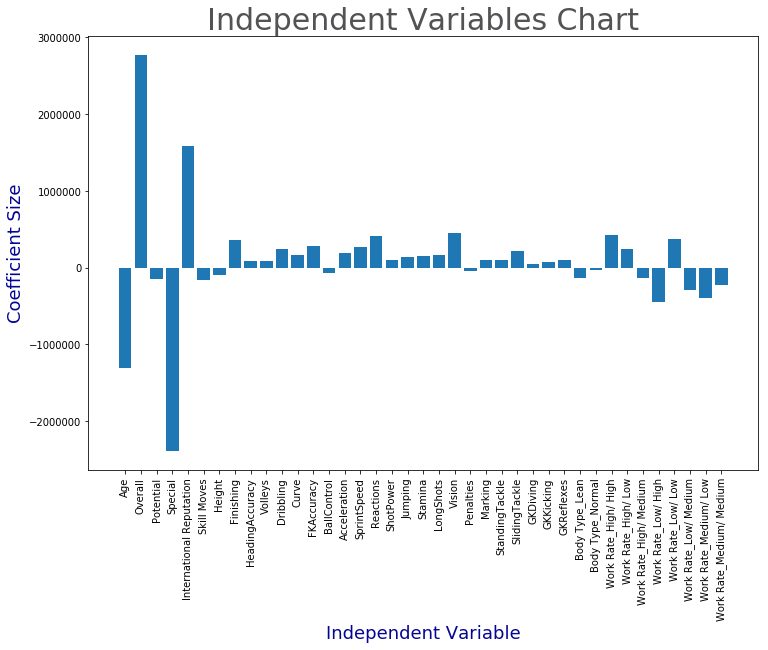

In [92]:
coefs = [item[0] for item in test]
varias = [item[1] for item in test]
plt.figure(figsize = (12,8))
plt.title("Independent Variables Chart", fontsize = 30, color = "#535355")
plt.xlabel("Independent Variable", fontsize = 18, color = "#050594")
plt.ylabel("Coefficient Size", fontsize = 18, color = "#050594")
plt.xticks(rotation=90)
plt.bar(varias, coefs)

## Random Forest

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 18,  test_size=.20)

In [94]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# y_train_new = [int(item) for item in y_train]
forest = RandomForestClassifier(criterion= "entropy", n_estimators=40, max_depth=10, min_samples_leaf = 5)
forest.fit(X_train, y_train.astype(int))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [95]:
forest.score(X_test, y_test.astype(int))

0.20357751277683134

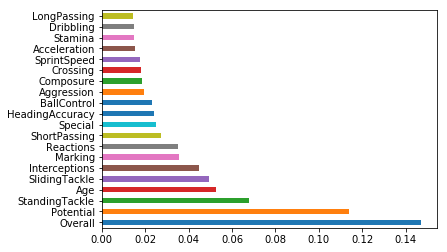

In [96]:
feat_importances = pd.Series(forest.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [ ]:
top_features = ['International Reputation', 'Overall', 'Acceleration', 'Finishing','Potential', 'Skill Moves', 
                'Work Rate_High/ High', 'Age', 'BallControl', 'LongPassing', 'Volleys', 'Finishing', 'Height', 'Curve', 'Reactions', 'Composure', 'StandingTackle', 'Work Rate_Low/ Low']

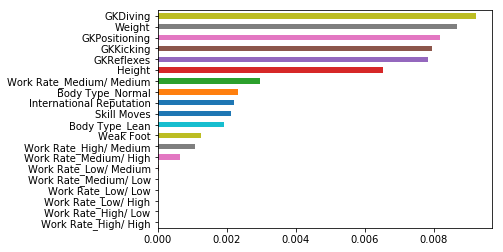

In [97]:
feat_importances = pd.Series(forest.feature_importances_, index=X.columns)
feat_importances.nsmallest(20).plot(kind='barh')

### Grid Search

In [ ]:
param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [1, 2, 5, 10],
    "min_samples_split": [2, 5, 10, 20],
    "n_estimators": [15, 20, 30, 40]
}

gs_tree = GridSearchCV(forest, param_grid, cv=3)
gs_tree.fit(X_train, y_train.astype(int))

gs_tree.best_params_

In [ ]:
dt_gs_training_score = np.mean(gs_tree.cv_results_['mean_train_score'])
dt_gs_testing_score = gs_tree.score(X_test, y_test.astype(int))

print("Mean Training Score: {:.4}%".format(dt_gs_training_score * 100))
print("Mean Testing Score: {:.4}%".format(dt_gs_testing_score * 100))
print("Best Parameter Combination Found During Grid Search:")
gs_tree.best_params_

### SVM Linear

In [98]:
from sklearn import svm
from sklearn.svm import SVR

svr_lin = SVR(kernel='linear', C=1e3)
y_lin_hat = svr_lin.fit(X_train, y_train).predict(X_test)

In [99]:
from sklearn.metrics import mean_squared_error

RMSE = np.sqrt(mean_squared_error(y_test, y_lin_hat))
z_score = RMSE/np.std(y_test)
R_squared = svr_lin.score(X_test, y_test)
print("RMSE = {}, z_score = {}, R_squared = {}".format(RMSE, z_score, R_squared))

RMSE = 3252161.6916327504, z_score = 0.7990983720267486, R_squared = 0.3614417918241999


In [100]:
def plot_top_features(model, X, num_features =10):
    coeffs = model.coef_.ravel()
    n = num_features
    feat_names = X.columns
    combo = list(zip(feat_names, coeffs))
    sorted_combos = sorted(combo, key = lambda x: x[1], reverse=True)
    features = [item[0] for item in sorted_combos]
    coeffi = [item[1] for item in sorted_combos]
    plt.figure(figsize=(10,6))
    plt.bar(features[:n], coeffi[:n])
    plt.xticks(rotation=90)
    plt.show()
    
def plot_bottom_features(model, X, num_features =10):
    coeffs = model.coef_.ravel()
    n = num_features
    feat_names = X.columns
    combo = list(zip(feat_names, coeffs))
    sorted_combos = sorted(combo, key = lambda x: x[1])
    features = [item[0] for item in sorted_combos]
    coeffi = [item[1] for item in sorted_combos]
    plt.figure(figsize=(10,6))
    plt.bar(features[:n], coeffi[:n])
    plt.xticks(rotation=90)
    plt.show()

In [101]:
coeffs = svr_lin.coef_.ravel()
feat_names = X.columns

In [80]:
len(coeffs) == len(feat_names)

True

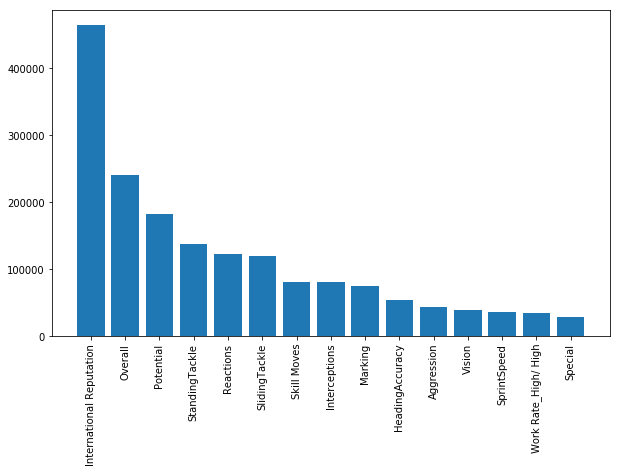

In [102]:
plot_top_features(svr_lin, X, 15)

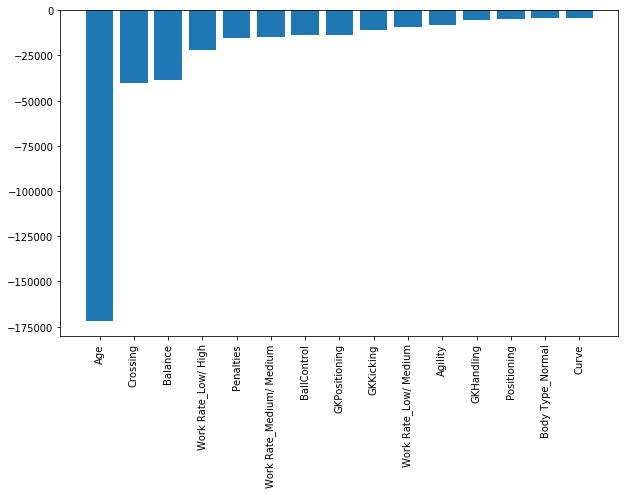

In [103]:
plot_bottom_features(svr_lin, X, 15)

### SVM Poly

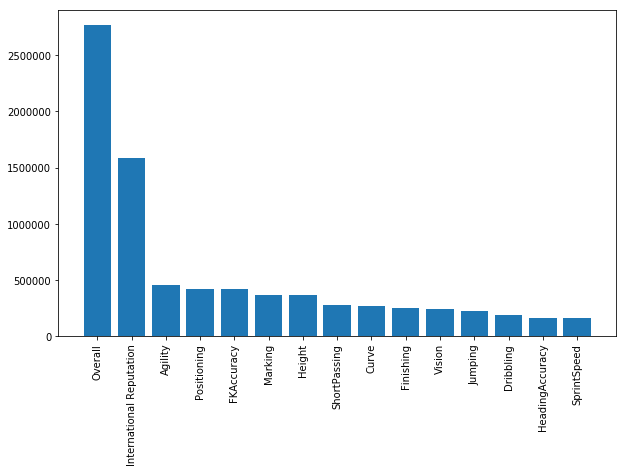

In [104]:
plot_top_features(linreg, X, 15)

In [ ]:
top_features = ['International Reputation', 'Overall', 'Potential', 'Skill Moves', 
                'Work Rate_High/ High', 'Age', 'BallControl', 'LongPassing', 'Volleys', 'Finishing', 'Height', 'Curve']

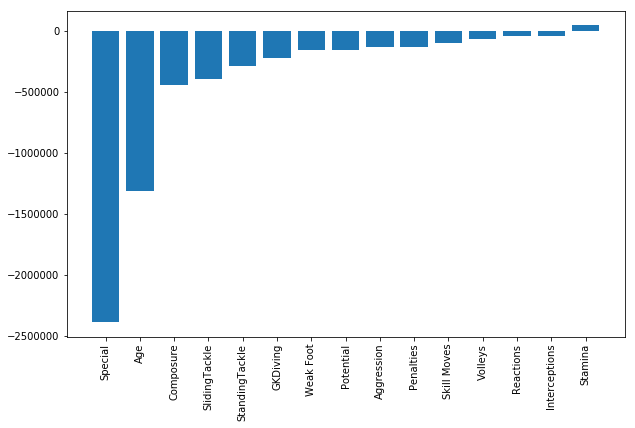

In [105]:
plot_bottom_features(linreg, X, 15)

In [ ]:
X_train.shape

### Deep Learning NNs

In [106]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
# Adding the input layer and the first hidden layer
model.add(Dense(30, activation = 'tanh', input_dim = 54))
# Adding the second hidden layer
model.add(Dense(22, activation = 'relu'))
# Adding the third hidden layer
model.add(Dense(15, activation = 'tanh'))
model.add(Dense(7, activation = 'tanh'))
# Adding the output layer
model.add(Dense(1, activation = 'linear'))
#model.add(Dense(1))
# Compiling the ANN
model.compile(optimizer = 'sgd', loss = 'mean_squared_error', metrics = ['mse'])
# Fitting the ANN to the Training set
model.fit(X_train, y_train, batch_size = 32,epochs = 100, validation_data=(X_test, y_test))



Train on 4692 samples, validate on 1174 samples
Epoch 1/100
4692/4692 [==============================] - 0s 87us/step - loss: 17134490145490.8242 - mean_squared_error: 17134490145490.8242 - val_loss: 16731060914165.5352 - val_mean_squared_error: 16731060914165.5352
Epoch 2/100
4692/4692 [==============================] - 0s 39us/step - loss: 17001477868684.5508 - mean_squared_error: 17001477868684.5508 - val_loss: 16573041579191.1680 - val_mean_squared_error: 16573041579191.1680
Epoch 3/100
4692/4692 [==============================] - 0s 42us/step - loss: 16986919251328.9805 - mean_squared_error: 16986919251328.9805 - val_loss: 16578499915657.3789 - val_mean_squared_error: 16578499915657.3789
Epoch 4/100
4692/4692 [==============================] - 0s 44us/step - loss: 16993302039371.2930 - mean_squared_error: 16993302039371.2930 - val_loss: 16566610435719.1934 - val_mean_squared_error: 16566610435719.1934
Epoch 5/100
4692/4692 [==============================] - 0s 42us/step - loss: 16

4692/4692 [==============================] - 0s 42us/step - loss: 16971441010473.2500 - mean_squared_error: 16971441010473.2500 - val_loss: 16596508070564.8496 - val_mean_squared_error: 16596508070564.8496
Epoch 39/100
4692/4692 [==============================] - 0s 40us/step - loss: 16991074775448.5527 - mean_squared_error: 16991074775448.5527 - val_loss: 16726723064219.6934 - val_mean_squared_error: 16726723064219.6934
Epoch 40/100
4692/4692 [==============================] - 0s 39us/step - loss: 16989430738793.8477 - mean_squared_error: 16989430738793.8477 - val_loss: 16576097047483.9648 - val_mean_squared_error: 16576097047483.9648
Epoch 41/100
4692/4692 [==============================] - 0s 39us/step - loss: 16968314138292.2676 - mean_squared_error: 16968314138292.2676 - val_loss: 16563543091901.2754 - val_mean_squared_error: 16563543091901.2754
Epoch 42/100
4692/4692 [==============================] - 0s 41us/step - loss: 16988064177875.6973 - mean_squared_error: 16988064177875.6

Epoch 75/100
4692/4692 [==============================] - 0s 41us/step - loss: 16971017528350.5527 - mean_squared_error: 16971017528350.5527 - val_loss: 16577974477260.5371 - val_mean_squared_error: 16577974477260.5371
Epoch 76/100
4692/4692 [==============================] - 0s 38us/step - loss: 16980514268204.5234 - mean_squared_error: 16980514268204.5234 - val_loss: 16597737073090.0723 - val_mean_squared_error: 16597737073090.0723
Epoch 77/100
4692/4692 [==============================] - 0s 42us/step - loss: 16997577092662.5605 - mean_squared_error: 16997577092662.5605 - val_loss: 16574732994800.7383 - val_mean_squared_error: 16574732994800.7383
Epoch 78/100
4692/4692 [==============================] - 0s 43us/step - loss: 16980058845410.9746 - mean_squared_error: 16980058845410.9746 - val_loss: 16615576330449.3379 - val_mean_squared_error: 16615576330449.3379
Epoch 79/100
4692/4692 [==============================] - 0s 45us/step - loss: 16988575982189.5586 - mean_squared_error: 169

In [107]:
model.evaluate(X_test, y_test)

1174/1174 [==============================] - 0s 15us/step


[16622978891161.95, 16622978891161.95]

In [108]:
from sklearn.metrics import r2_score

y_pred = model.predict(X_test)

RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
z_score = RMSE/np.std(y_test)
# R_squared = r2_score(X_test, y_test)
# print("RMSE = {}, z_score = {}, R_squared = {}".format(RMSE, z_score, R_squared))

In [109]:
RMSE, z_score

(4077128.811353574, 1.001803509363736)

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
top_features = ['International Reputation', 'Overall', 'Acceleration', 'Finishing','Potential', 'Skill Moves', 
                'Work Rate_High/ High', 'Age', 'BallControl', 'LongPassing', 'Volleys', 'Finishing', 'Height', 'Curve', 'Reactions', 'Composure', 'StandingTackle', 'Work Rate_Low/ Low']

In [ ]:
len(top_features)

In [ ]:
ultra_df = X[top_features]

In [ ]:
ultra_df.head()

In [ ]:
chart.Position.value_counts()